In [15]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
def read_data():
    
    data = pd.read_csv("dataframe.csv")
    data["dependencies"].fillna("", inplace=True)
    data["relevant_dependencies"].fillna("", inplace=True)
    data["dependencies"] = data["dependencies"].apply(lambda x: x.split("),"))
    data["relevant_dependencies"] = data["relevant_dependencies"].apply(lambda x: x.split("),"))
    data.drop('recommended_exclusion', axis=1, inplace=True)
    data.drop('sentence_id', axis=1, inplace=True)
    
    return data


def process_data(data):
    dataset = []
    feature_set = []
    typeCount = {}
    for i, (position, word, gerund, tags, dependencies, relDependencies, sentence) in data.iterrows():
        feature_set.append(gerund)
        feature_set.append(word)
        typeCount[gerund] = typeCount[gerund] + 1 if gerund in typeCount else 0   
        for dependency in relDependencies:
            if len(dependency.split())<3:
                continue
            id = dependency.split()[0]
            w1 = dependency.split()[1][1:-1].split("-")[0]
            p1 = dependency.split()[1][1:-1].split("-")[1]
            w2 = dependency.split()[2].split("-")[0]
            p2 = dependency.split()[2].split("-")[1]
            organized_dependency = (id, w1, p1, w2, p2)
            feature_set.append(organized_dependency)  
        dataset.append(feature_set)
        feature_set = []
    print(typeCount)
    return dataset

def makeArray(item, dependencies):
    features = {"gerund": item[0]}
    features.update({f: 0 for f in dependencies})
    for feature in item[2:]:
        features[feature[0]] = 1
    return features

def count_identifiers(data):
    identifier_counts = {}
    for item in data:
        dependencies = item[2:]
        for dependency in dependencies:
            identifier = dependency[0]
            identifier_counts[identifier] = identifier_counts.get(identifier, 0) + 1
    return identifier_counts


In [32]:
data = read_data()
goodData = process_data(data)
dependencies = list(count_identifiers(goodData).keys())
dicts = [makeArray(s, dependencies) for s in goodData]

p_data = pd.DataFrame.from_dict(dicts)
#print(p_data.col["gerund"].isin(""))


{'vp-ing': 41659, 'ing-of': 2981, 'poss-ing': 1248, 'acc-ing': 5953, 'det-ing': 2958, 'poss-ing-of': 254}


Chi squared test:

In [18]:
def split_df_by_gerund(df, gerund_column):
    
    # Get unique "gerund" values
    unique_gerunds = df[gerund_column].unique()

    # Create a dictionary to store the resulting DataFrames
    gerund_dfs = {}

    # Split the DataFrame by "gerund" values
    for gerund in unique_gerunds:
        gerund_df = df[df[gerund_column] == gerund]
        gerund_dfs[gerund] = gerund_df

    return gerund_dfs

In [19]:


# Separate the label column from the other columns
#dfs = split_df_by_gerund(p_data, "gerund")
#vp_ing = p_data.drop(p_data[p_data.gerund != "vp-ing"].index, axis=1)
#print(dfs["acc-ing"])
#X = dfs["ing-of"].drop('gerund', axis=1) # Features

#drop acc-ing
#p_data = p_data[p_data['gerund'] != 'acc-ing'] 

X = p_data.drop('gerund', axis=1)
y = p_data['gerund'] # type


In [20]:

# Perform chi-squared test for feature selection
selector = SelectKBest(score_func=chi2, k=10)
X_new = selector.fit_transform(X, y)

# Get the indices of the top k features
top_k_indices = selector.get_support(indices=True)

# Get the column names of the top k features
top_k_features = X.columns[top_k_indices]

# Print the top k features
print("The top features are:")
print(top_k_features)

The top features are:
Index(['obj', 'advcl', 'mark', 'case', 'amod', 'nmod', 'det', 'nmod:poss',
       'nsubj', 'compound'],
      dtype='object')


In [21]:
rf = RandomForestClassifier()
rf.fit(X, y)

# Extract feature importances
feature_importances = rf.feature_importances_

#print(feature_importances)

# Create a dictionary to store feature importances for each label
feature_importances_by_label = {}
for i, label in enumerate(y.unique()):
    feature_importances_by_label[label] = feature_importances[i]

# Print feature importances for each label
for label, importance in feature_importances_by_label.items():
    print(label + ": " + str(importance))
    


vp-ing: 0.003441181392341865
ing-of: 0.009561507417721979
poss-ing: 0.002765829068627155
det-ing: 0.014435717365641134
poss-ing-of: 0.012162356558666204


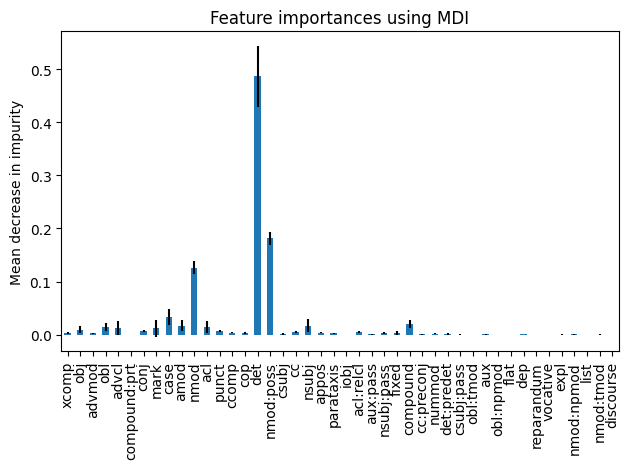

In [22]:
forest_importances = pd.Series(feature_importances, index=dependencies)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig("mygraph.png")

doc classification

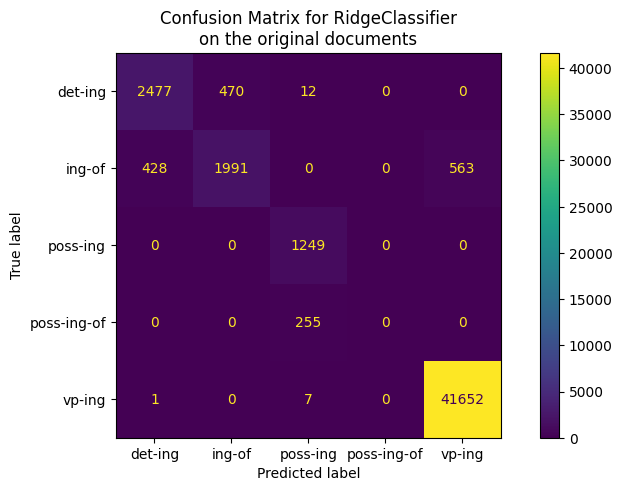

In [33]:

from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
lables = ["det-ing", "ing-of", "poss-ing", "poss-ing-of", "vp-ing"]

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X, y)
pred = clf.predict(X)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y, pred, ax=ax)
ax.xaxis.set_ticklabels(lables)
ax.yaxis.set_ticklabels(lables)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)
plt.savefig("confusionMatrix")


top 5 keywords per class:
     vp-ing ing-of   poss-ing    det-ing poss-ing-of
0       det   nmod  nmod:poss       nmod        case
1      case    det       case  nmod:poss         acl
2  compound    obl       amod        obl        mark


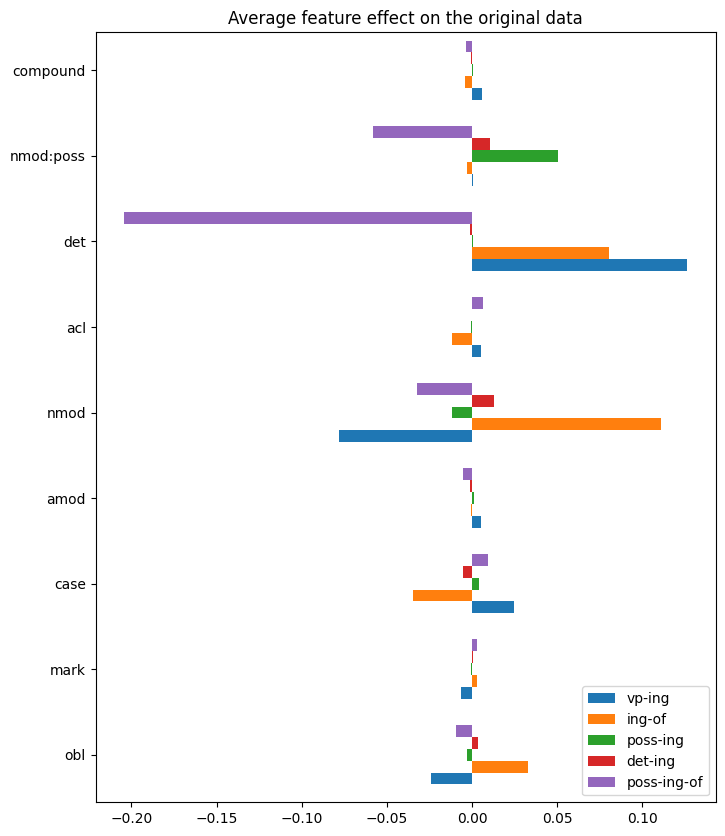

In [30]:
def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X.mean(axis=0)).ravel()

    for i, label in enumerate(y.unique()):
        top5 = np.argsort(average_feature_effects[i])[-3:][::-1]
        if i == 0:
            top = pd.DataFrame(np.array(dependencies)[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = np.array(dependencies)[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = np.array(dependencies)[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.80
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(8, 10))
    for i, label in enumerate(y.unique()):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax


_ = plot_feature_effects().set_title("Average feature effect on the original data")
plt.savefig("")